# Manual music

## Preliminaries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [29]:
# All gesture ids
GESTURES = [
  '00-gamma-ut',
  '01-are',
  '02-bmi',
  '03-cfaut',
  '04-dsolre',
  '05-elami',
  '06-ffaut',
  '07-gsolreut',
  '08-alamire',
  '09-bmifa',
  '10-csolfaut',
  '11-dlasolre',
  '12-elami',
  '13-ffaut',
  '14-gsolreut',
  '15-alamire',
  '16-bmifa',
  '17-cesolla',
  '18-delasol',
  '19-ela',
  'none'
]

# Hand landmarks
WRIST = 0
THUMB_CMC = 1
THUMB_MCP = 2
THUMB_IP = 3
THUMB_TIP = 4
INDEX_FINGER_MCP = 5
INDEX_FINGER_PIP = 6
INDEX_FINGER_DIP = 7
INDEX_FINGER_TIP = 8
MIDDLE_FINGER_MCP = 9
MIDDLE_FINGER_PIP = 10
MIDDLE_FINGER_DIP = 11
MIDDLE_FINGER_TIP = 12
RING_FINGER_MCP = 13
RING_FINGER_PIP = 14
RING_FINGER_DIP = 15
RING_FINGER_TIP = 16
PINKY_MCP = 17
PINKY_PIP = 18
PINKY_DIP = 19
PINKY_TIP = 20

LANDMARKS = ["wrist", "thumb_cmc", "thumb_mcp", "thumb_ip", "thumb_tip", "index_finger_mcp", "index_finger_pip", "index_finger_dip", "index_finger_tip", "middle_finger_mcp", "middle_finger_pip", "middle_finger_dip", "middle_finger_tip", "ring_finger_mcp", "ring_finger_pip", "ring_finger_dip", "ring_finger_tip", "pinky_mcp", "pinky_pip", "pinky_dip", "pinky_tip"]

# Connections that form the hand
HAND_PALM_CONNECTIONS = ((0, 1), (0, 5), (9, 13), (13, 17), (5, 9), (0, 17))
HAND_THUMB_CONNECTIONS = ((1, 2), (2, 3), (3, 4))
HAND_INDEX_FINGER_CONNECTIONS = ((5, 6), (6, 7), (7, 8))
HAND_MIDDLE_FINGER_CONNECTIONS = ((9, 10), (10, 11), (11, 12))
HAND_RING_FINGER_CONNECTIONS = ((13, 14), (14, 15), (15, 16))
HAND_PINKY_FINGER_CONNECTIONS = ((17, 18), (18, 19), (19, 20))
HAND_CONNECTIONS = frozenset().union(*[
    HAND_PALM_CONNECTIONS, HAND_THUMB_CONNECTIONS,
    HAND_INDEX_FINGER_CONNECTIONS, HAND_MIDDLE_FINGER_CONNECTIONS,
    HAND_RING_FINGER_CONNECTIONS, HAND_PINKY_FINGER_CONNECTIONS
])

## Data loading and cleaning

Data was collected by playing a script that asked to show a certain gesture with the left hand for 5s while rotating your hand. After that, you relax the hand for 2s, and then you show the gesture again for 5s, etc. The gesture is shown a total of 10 times (50s) and the hand positions are recorded at roughly 5 frames per second, resulting in around 250 data points. However, the frames right after a break and right before a break are discarded, as the gesture may not be in place yet, or already out of place. A offset of 1000ms is used. In short, we record approximately 10 x 3s x 5 = 150 positions for each gesture.

The functions below clean the JSON files and filter out only the hand postures at the 'middle' of each step.

In [7]:
def get_steps(data):
  """Basically add the step number to the step dictionaries"""
  steps = [*data['script']['steps']]
  for i, step in enumerate(steps):
    step['step'] = i
  return steps

def get_events_per_step(data):
  """Group all events by step"""
  events = {}
  for event in data['events']:
    if event['handsPresent']:
      results = event.pop('results')
      event['coords'] = pd.DataFrame(results['landmarks'][0]).values
      step = event['step']
      if step not in events:
        events[step] = []
      events[step].append(event)
  return events

def filter_gesture_events(events, steps, offset=1000):
  """Filter out steps with an 'activeIndex' and remove initial and final events that are closer than {offset}ms to the start/end of the step"""
  steps_with_gesture = [s for s in steps if 'activeIndex' in s]

  filtered = {}
  for step in steps_with_gesture:
    stepEvents = events[step['step']]
    startTime = stepEvents[0]['time']
    endTime = stepEvents[-1]['time']
    filtered[step['step']] = [
      e for e in stepEvents 
      if (e['time'] > startTime + offset) & (e['time'] < endTime - offset)
    ]
  return filtered

Each hand position is represented by 3D coordinates of 21 points (landmarks). The coordinates are flattened to 3x21 = 63 dimensional feature vectors. The following functions collect the feature vectors in usual data matrix $X$ and the corresponding labels in $y$.

In [10]:
def to_training_data(events_by_step, class_index):
  """Export to an array X with 3x21 = 63 features, and a target array y with the class index"""
  X = []
  for step, stepEvents in events_by_step.items():
    X.extend([e['coords'].flatten() for e in stepEvents])
  X = np.array(X)
  y = np.array([class_index] * len(X))
  return X, y

def process_data(filename, gesture_id, offset=1000):
  with open(filename, 'r') as f:
    data = json.load(f)
  
  steps = get_steps(data)
  events = get_events_per_step(data)
  filtered = filter_gesture_events(events, steps, offset=offset)
  X, y = to_training_data(filtered, GESTURES.index(gesture_id))
  return filtered, X, y

def to_df(X, y):
  columns = []
  for landmark in LANDMARKS:
    columns.extend([f'{landmark}_x', f'{landmark}_y', f'{landmark}_z'])
  df = pd.DataFrame(X, columns=columns)
  df['gesture'] = y
  df['gesture_name'] = df['gesture'].apply(lambda x: GESTURES[x])
  return df

Putting it all together:

In [21]:
events_by_step, X, y = process_data('data/02-bmi.json', '02-bmi')
events_by_step[2]

[{'time': 218753,
  'step': 2,
  'handsPresent': True,
  'coords': array([[ 6.82602882e-01,  7.99423933e-01, -5.11319001e-07],
         [ 6.16952896e-01,  7.32083559e-01, -2.57489327e-02],
         [ 5.75942695e-01,  6.15936160e-01, -4.56001386e-02],
         [ 5.48255920e-01,  5.26176155e-01, -6.80919215e-02],
         [ 5.17226994e-01,  4.49498683e-01, -8.74471813e-02],
         [ 6.56549931e-01,  5.02968967e-01,  4.03793110e-03],
         [ 6.32802784e-01,  4.48555022e-01, -4.81468849e-02],
         [ 6.14020050e-01,  5.26318729e-01, -9.32376757e-02],
         [ 6.04541183e-01,  6.02247775e-01, -1.16774954e-01],
         [ 7.11387277e-01,  4.93424982e-01, -4.64110775e-03],
         [ 7.05267727e-01,  3.93531442e-01, -4.75303046e-02],
         [ 6.69014096e-01,  3.58544171e-01, -8.14958364e-02],
         [ 6.32052302e-01,  3.36111546e-01, -1.00475788e-01],
         [ 7.62018204e-01,  5.17551422e-01, -2.26392224e-02],
         [ 7.86601603e-01,  4.01521146e-01, -5.87627888e-02],
     

## Drawing

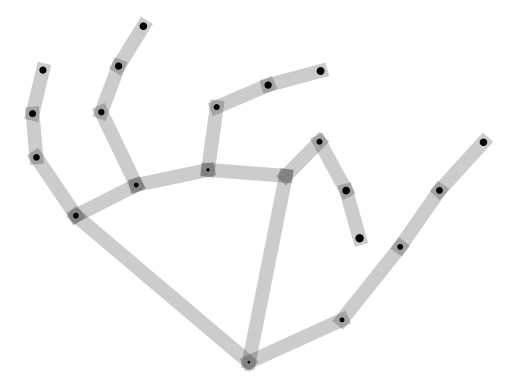

In [22]:
def draw_hand(coordinates, scale=1, ax=None):
  if ax is not None: plt.sca(ax)
  x, y, z = coordinates.T
  for a, b in HAND_CONNECTIONS:
    plt.plot([x[a], x[b]], [y[a], y[b]], 'k-', alpha=.2, lw=scale * 10)

  s = 1 - (z - z.min()) / (z.max() - z.min())
  plt.scatter(x, y, s=s * 25 * scale, c='k')

  plt.axis('off');
  plt.gca().invert_xaxis()
  plt.gca().invert_yaxis()

draw_hand(events_by_step[2][0]['coords'])

All recorded hand positions in a given recording session. Note that these are *all* the same gesture, but since the hand was constantly moved and rotated, they sometimes look quite different.

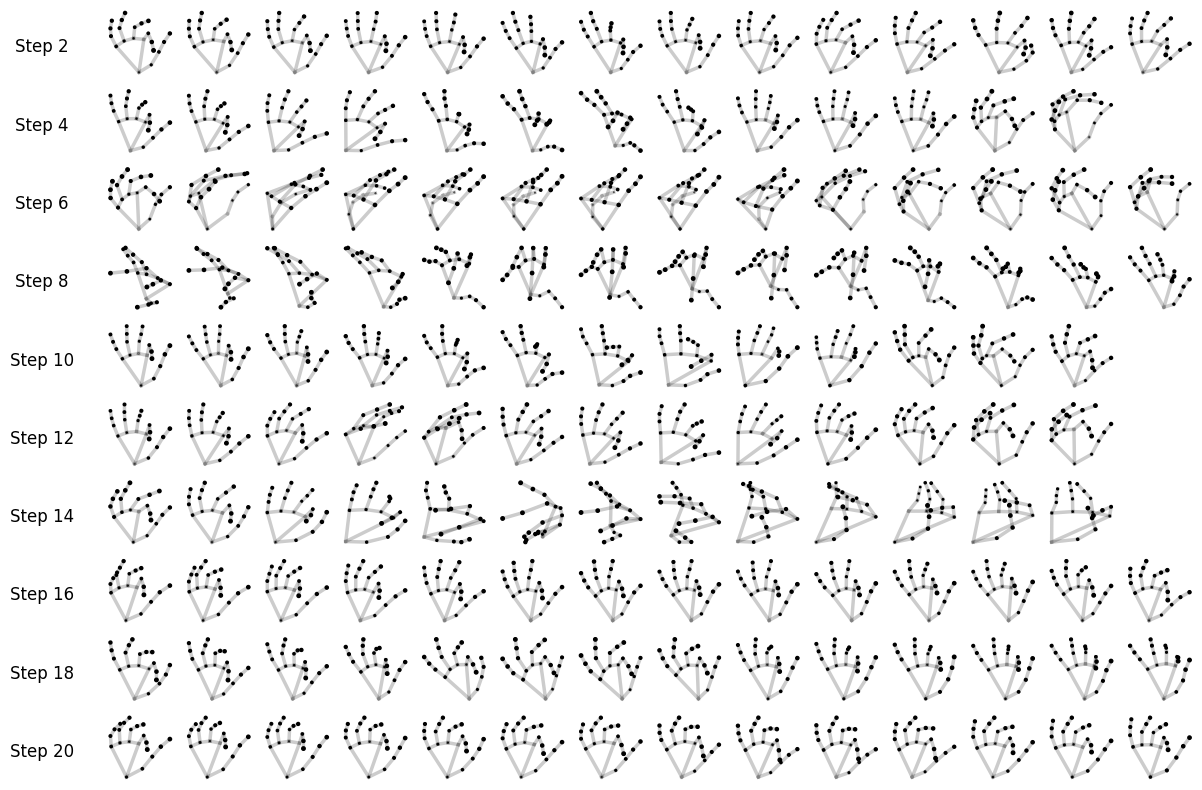

In [23]:
def draw_all_hands(events_by_step):
  numSteps = len(events_by_step)
  numEvents = max([len(events) for events in events_by_step.values()])
  _, axes = plt.subplots(numSteps, numEvents, figsize=(numEvents, numSteps))

  for i, (step, stepEvents) in enumerate(events_by_step.items()):
    for j in range(numEvents):
      plt.sca(axes[i, j])
      plt.axis('off')
      if j < len(stepEvents):
        draw_hand(stepEvents[j]['coords'], ax = axes[i, j], scale=.25)
      
      
    axes[i, 0].set_title(f"Step {step}", x=-1, y=.3, va='center')

draw_all_hands(events_by_step)

## Export data to csv

In [25]:
FILES = [(f'data/{g}.json', g) for g in GESTURES]
X, y = [], []
for file, gesture_id in FILES:
  _, _X, _y = process_data(file, gesture_id)
  X.append(_X)
  y.append(_y)

df = to_df(np.concatenate(X), np.concatenate(y))
df.to_csv('data.csv', index=False)

## Loading the data

In [26]:
df = pd.read_csv('data.csv')
y = df['gesture']
X = df.drop(columns=['gesture', 'gesture_name'])

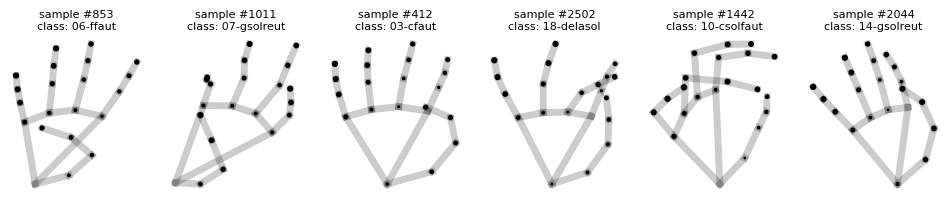

In [27]:
# Draw some hands
N = 6
rows = np.random.randint(0, len(X), N)
fig, axes = plt.subplots(1, N, figsize=(2 * N, 2))
for i, row in enumerate(rows):
  coords = X.iloc[row, :].values.reshape(21, 3)
  draw_hand(coords, scale=.5, ax=axes[i])
  plt.title(f'sample #{row}\nclass: {df.iloc[row, -1]}', fontsize=8)